<h1 style='color: green; font-size: 26px; font-weight: bold;'> 3. Previsão de falha <h1>

### Notebook 2
1.  Pré Processamento II
2. Feature engineering
3. Modelagem
4. Avaliação
5. Modelo final
6. Conclusão.

<strong>Descripción</strong>
<p>Los galpones de Full de mercado libre cuentan con una flota de dispositivos que transmiten
diariamente telemetría agregada en varios atributos.
Las técnicas de mantenimiento predictivo están diseñadas para ayudar a determinar la
condición del equipo de mantenimiento en servicio para predecir cuándo se debe realizar el
mantenimiento. Este enfoque promete ahorros de costos sobre el mantenimiento preventivo
de rutina o basado en el tiempo porque las tareas se realizan solo cuando están justificadas.
</p>

<strong>Entregable</strong>
<p>Tiene la tarea de generar una Jupyter notebook con un modelo predictivo para predecir la
probabilidad de falla del dispositivo con el objetivo de bajar los costos del proceso. Como
una referencia, una falla de un dispositivo tiene un costo de 1 mientras el costo de un
mantenimiento es 0,5. El archivo "full_devices.csv" tiene los valores diários para los 9
atributos de los dispositivos y la columna que está tratando de predecir se llama 'failure' con
el valor binario 0 para no fallar y 1 para fallar
</p>

# Carregando os dados

In [258]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

In [259]:
dir_data = "F:\PycharmProjects\DesaioMELI\data"
df = pd.read_csv(dir_data+r'\full_devices.csv', sep=',', encoding='ISO-8859-1')
df.head()

date    device  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-01  S1F0166B        0    61370680           0           3   
2  2015-01-01  S1F01E6Y        0   173295968           0           0   
3  2015-01-01  S1F01JE0        0    79694024           0           0   
4  2015-01-01  S1F01R2B        0   135970480           0           0   

   attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  
0          52           6      407438           0           0           7  
1           0           6      403174           0           0           0  
2           0          12      237394           0           0           0  
3           0           6      410186           0           0           0  
4           0          15      313173           0           0           3

coluna 'failure'
1 = Equipamento falhou
0 = Equipamento não falhou

'device'
equipamento monitorado

'attribute1'
pode ser algum código, não tenho certeza.


In [260]:
df.nunique()

date             304
device          1169
failure            2
attribute1    123877
attribute2       558
attribute3        47
attribute4       115
attribute5        60
attribute6     44838
attribute7        28
attribute8        28
attribute9        65
dtype: int64

In [261]:
df.groupby(['device']).agg(['count']).shape

(1169, 11)

In [262]:
df.groupby(['date']).agg(['count']).shape

(304, 11)

# Pré processamento II

In [263]:
#Tranformando os tipos de dados
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   attribute1  124494 non-null  int64         
 4   attribute2  124494 non-null  int64         
 5   attribute3  124494 non-null  int64         
 6   attribute4  124494 non-null  int64         
 7   attribute5  124494 non-null  int64         
 8   attribute6  124494 non-null  int64         
 9   attribute7  124494 non-null  int64         
 10  attribute8  124494 non-null  int64         
 11  attribute9  124494 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


In [264]:
df = df.drop_duplicates()

Eliminando o registro duplicado identificado no notebook 1

In [265]:
df.shape

(124493, 12)

In [266]:
df.groupby(['failure'])['device'].count()

failure
0    124387
1       106
Name: device, dtype: int64

In [267]:
#percentual de falha em 11 meses
print('Percentual de falha: {:.5f}%'.format(df.groupby(['failure'])['device'].count().iloc[1] / df['device'].count()))

Percentual de falha: 0.00085%


In [268]:
#ordenando o dataset por data e pelo device para posteriormente verificar o histórico até a falha
df = df.sort_values(by=['device','date'], ascending=[True, True])
df['flipper'] = np.where((df.device != df.device.shift(1)), 1, 0)
df.head()

date    device  failure  attribute1  attribute2  attribute3  \
0    2015-01-01  S1F01085        0   215630672          56           0   
1163 2015-01-02  S1F01085        0     1650864          56           0   
2326 2015-01-03  S1F01085        0   124017368          56           0   
3489 2015-01-04  S1F01085        0   128073224          56           0   
4651 2015-01-05  S1F01085        0    97393448          56           0   

      attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  \
0             52           6      407438           0           0           7   
1163          52           6      407438           0           0           7   
2326          52           6      407438           0           0           7   
3489          52           6      407439           0           0           7   
4651          52           6      408114           0           0           7   

      flipper  
0           1  
1163        0  
2326        0  
3489        0  
4651        0

<strong>Pensando no oversampling, somente duplicar os dados pode gerar overfitting, pois existe um tempo de vida para cada dispositivo e um período de uso para falha, visto que não é um evento comum, então introduzir somente os registros de falhas, sem considerar os dados que antecem o evento resultará em um viés que acarretará em overfitting. O viés é inevitavél, mas o ideal é que acompanhe o comportamento dos dados.</strong>

Dito isso, vou criar algumas features para obter essa informação de comportamento dos dados até a falha e com isso gerar os novos registros, além de tranformar os dados de colunas para melhor se adequarem a modelagem.

In [269]:
#pega o 1º registro para cada dispositivo, com a coluna criada 'flipper'
starter = df[df['flipper'] == 1]
starter = starter[['date','device']]
starter = starter.rename(index=str, columns={"date": "start_date"})
starter['start_date'] = pd.to_datetime(starter['start_date'])

In [270]:
#Merge start_date com o dataset original, para marcar a data de inicio de monitoramento de cada dispositivo
df = df.sort_values(by=['device', 'date'], ascending=[True, True])
starter = starter.sort_values(by=['device'], ascending=[True])
df = df.merge(starter, on=['device'], how='left')

In [271]:
df[df['failure'] == 1].groupby(['date','start_date'])['device'].count()

date        start_date
2015-01-05  2015-01-01    1
2015-01-07  2015-01-01    1
2015-01-09  2015-01-01    1
2015-01-13  2015-01-01    1
2015-01-14  2015-01-01    1
                         ..
2015-08-04  2015-01-01    1
2015-08-18  2015-01-01    1
2015-10-05  2015-01-01    1
2015-10-09  2015-01-01    1
2015-10-26  2015-01-01    1
Name: device, Length: 76, dtype: int64

In [272]:
# Calcula os dias até a falha para cada dispositivo, contando a partir do momento que se iniciou a monitoria do dispositivo
#Isso irá servir para encontrar o valor do ciclo para usar como janela no agrupamento
devices = df['device'].unique()
failure_record = []
no_failured = []
for device in devices:
    start_date = df.loc[(df['device'] == device) & (df['flipper'] == 1), 'date'].iloc[0]
    falhas_dispositivo = df.loc[(df['device'] == device) & (df['failure'] == 1), 'date']
    if not falhas_dispositivo.empty:
        data_falha = falhas_dispositivo.min()
        dias_decorridos = (data_falha - start_date).days
        failure_record.append({
            'device': device,
            'count_days': dias_decorridos,
            'start_date': start_date,
            'failure_date': data_falha.date()
        })
    else:
        no_failured.append({
            'device': device,
            'start_date': start_date,
        })

In [273]:
#Dataframe com os dispositivos que falharam e outro com os que não falharam
df_failured_record = pd.DataFrame(failure_record).sort_values(by='failure_date').reset_index(drop=True)
df_non_failured_record = pd.DataFrame(no_failured).sort_values(by='start_date').reset_index(drop=True)

In [274]:
df_non_failured_record

device start_date
0     S1F01085 2015-01-01
1     W1F0X5L3 2015-01-01
2     W1F0X5L8 2015-01-01
3     W1F0X5N2 2015-01-01
4     W1F0X5TL 2015-01-01
...        ...        ...
1058  S1F02W1L 2015-05-06
1059  S1F02XLX 2015-05-06
1060  S1F013BB 2015-05-06
1061  S1F03499 2015-05-06
1062  W1F1DA5ÿ 2015-06-13

[1063 rows x 2 columns]

In [275]:
df_failured_record

device  count_days start_date failure_date
0    S1F0RRB1           4 2015-01-01   2015-01-05
1    S1F0CTDN           6 2015-01-01   2015-01-07
2    W1F0PNA5           8 2015-01-01   2015-01-09
3    W1F13SRV          12 2015-01-01   2015-01-13
4    W1F1230J          13 2015-01-01   2015-01-14
..        ...         ...        ...          ...
101  W1F1CB5E         215 2015-01-01   2015-08-04
102  Z1F0MRPJ         229 2015-01-01   2015-08-18
103  S1F0JGJV         277 2015-01-01   2015-10-05
104  Z1F14BGY         281 2015-01-01   2015-10-09
105  W1F0T0B1         298 2015-01-01   2015-10-26

[106 rows x 4 columns]

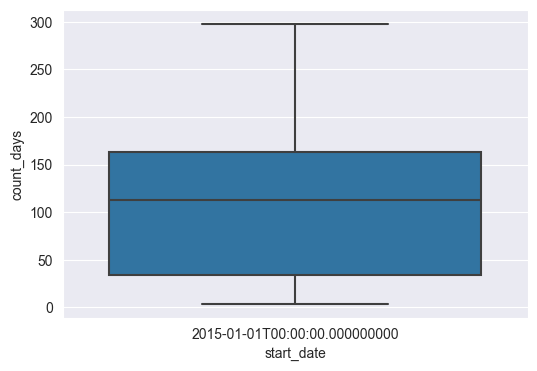

In [276]:
plt.figure(figsize=(6,4))
sns.boxplot(x= 'start_date',y='count_days',data=df_failured_record)
plt.show()

array([[<Axes: title={'center': 'count_days'}>,
        <Axes: title={'center': 'start_date'}>]], dtype=object)

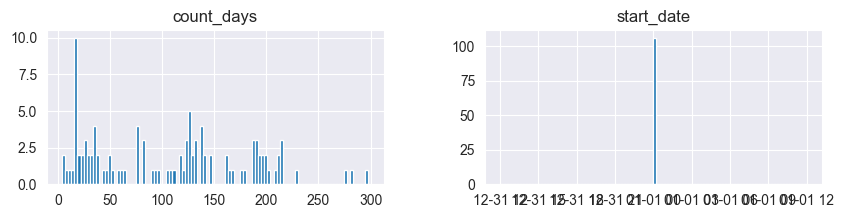

In [277]:
#Distribuição dos dispositivos que falharam em dias corrido a partir do inicio da monitoria de cada um
ax = df_failured_record.hist(bins=100, figsize=(10,2))
ax

In [278]:
df_failured_record.describe()

count_days
count  106.000000
mean   106.905660
std     74.017826
min      4.000000
25%     34.000000
50%    113.000000
75%    163.250000
max    298.000000

In [279]:
#mediana
df_failured_record.mode()

device  count_days start_date failure_date
0    S1F023H2        18.0 2015-01-01   2015-01-19
1    S1F03YZM         NaN        NaT          NaN
2    S1F09DZQ         NaN        NaT          NaN
3    S1F0CTDN         NaN        NaT          NaN
4    S1F0DSTY         NaN        NaT          NaN
..        ...         ...        ...          ...
101  Z1F1901P         NaN        NaT          NaN
102  Z1F1AG5N         NaN        NaT          NaN
103  Z1F1FCH5         NaN        NaT          NaN
104  Z1F1RJFA         NaN        NaT          NaN
105  Z1F1VQFY         NaN        NaT          NaN

[106 rows x 4 columns]

In [280]:
#Falhas ranqueada por data
df_failured_record.groupby('failure_date')['device'].count().sort_values(ascending=False)

failure_date
2015-01-19    8
2015-05-08    3
2015-02-04    3
2015-07-20    2
2015-03-17    2
             ..
2015-04-20    1
2015-04-21    1
2015-04-27    1
2015-01-07    1
2015-10-26    1
Name: device, Length: 76, dtype: int64

Todos os dispositivos que falharam são monitorados desde o dia 01-01 e 75% deles falharam em até 163 dias após essa data.
O dia que mais dispositivos falharam aconteceu 18 dias após a data de inicio da monitoria, no total foram 8 dispositivos.
Vou utilizar essa janela de dias para fazer a Sobreamostragem e agregação dos dados dos sensores.

# Feature engineering

### Novas colunas auxiliares

In [281]:
#Esta é a janela pela qual será feita a agregação dos valores das colunas.
window = 18

In [282]:
#pegando o primeiro registro para cada máqui, com a coluna flipper
df.head()

date    device  failure  attribute1  attribute2  attribute3  \
0 2015-01-01  S1F01085        0   215630672          56           0   
1 2015-01-02  S1F01085        0     1650864          56           0   
2 2015-01-03  S1F01085        0   124017368          56           0   
3 2015-01-04  S1F01085        0   128073224          56           0   
4 2015-01-05  S1F01085        0    97393448          56           0   

   attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  \
0          52           6      407438           0           0           7   
1          52           6      407438           0           0           7   
2          52           6      407438           0           0           7   
3          52           6      407439           0           0           7   
4          52           6      408114           0           0           7   

   flipper start_date  
0        1 2015-01-01  
1        0 2015-01-01  
2        0 2015-01-01  
3        0 2015-01-01  
4        0 2015-01-01

In [283]:
#Calcula o número de dias corridos para cada dispositivo até atingir 'window',
df['count_days'] = df['date'] - df['start_date']
df['time_since_start'] = df['count_days'] / np.timedelta64(1, 'D')
df = df.drop(columns=['count_days'])
# quando valor for 1, o histórico de monitoramento do dispositivo tem menos que 18 dias
df['too_soon'] = np.where((df.time_since_start < window) , 1, 0)
df.head()

date    device  failure  attribute1  attribute2  attribute3  \
0 2015-01-01  S1F01085        0   215630672          56           0   
1 2015-01-02  S1F01085        0     1650864          56           0   
2 2015-01-03  S1F01085        0   124017368          56           0   
3 2015-01-04  S1F01085        0   128073224          56           0   
4 2015-01-05  S1F01085        0    97393448          56           0   

   attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  \
0          52           6      407438           0           0           7   
1          52           6      407438           0           0           7   
2          52           6      407438           0           0           7   
3          52           6      407439           0           0           7   
4          52           6      408114           0           0           7   

   flipper start_date  time_since_start  too_soon  
0        1 2015-01-01               0.0         1  
1        0 2015-01-01               1.0         1  
2        0 2015-01-01               2.0         1  
3        0 2015-01-01               3.0         1  
4        0 2015-01-01               4.0         1

In [284]:
#Drop da coluna attribute8 por ter correlação perfeita positiva com a attribute9
df.drop('attribute8', axis=1, inplace=True)
df.head()

date    device  failure  attribute1  attribute2  attribute3  \
0 2015-01-01  S1F01085        0   215630672          56           0   
1 2015-01-02  S1F01085        0     1650864          56           0   
2 2015-01-03  S1F01085        0   124017368          56           0   
3 2015-01-04  S1F01085        0   128073224          56           0   
4 2015-01-05  S1F01085        0    97393448          56           0   

   attribute4  attribute5  attribute6  attribute7  attribute9  flipper  \
0          52           6      407438           0           7        1   
1          52           6      407438           0           7        0   
2          52           6      407438           0           7        0   
3          52           6      407439           0           7        0   
4          52           6      408114           0           7        0   

  start_date  time_since_start  too_soon  
0 2015-01-01               0.0         1  
1 2015-01-01               1.0         1  
2 2015-01-01               2.0         1  
3 2015-01-01               3.0         1  
4 2015-01-01               4.0         1

### Oversamplig - gerando mais casos de falha para balanceamento das classes

No primeiro momento vou testar a janela encontrada com a moda da coluna de datas para falhas.
A técnica será a de SMOTE (Synthetic Minority Over-sampling Technique), ela gera amostras sintéticas da classe minoritária. Para cada exemplo da classe minoritária é selecionado aleatóriamente um valor k vizinhos mais próximos para criar novos exemplos. Usarei a janela (18) para K e a quantidade de amostras ((taxa de oversampling) será determinada pela razão: (tamanho_nao_falhas / tamanho_falhas) - 1) / 10.

In [285]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime


#trasformação da coluna de dispositivos
encoder = LabelEncoder()

df['device_encolder'] = encoder.fit_transform(df['device'])
print('Quantidade de device: {} e device Encoder: {}'.format(df['device'].nunique(), df['device_encolder'].nunique()))
df.drop('device', axis=1, inplace=True)

#colunas de datas precisam ser convertidas
df["date"] = (pd.to_datetime(df["date"]) - datetime(1970, 1, 1)).dt.total_seconds()
df["start_date"] = (pd.to_datetime(df["start_date"]) - datetime(1970, 1, 1)).dt.total_seconds()

Quantidade de device: 1169 e device Encoder: 1169


In [286]:
from collections import Counter
from imblearn.over_sampling import SMOTE

def oversamplit_SMOTE(data):
    # Separando as features e o target
    X = data.drop('failure', axis=1)
    y = data['failure']

    # Verifique a contagem de classe antes do oversampling
    print('Contagem de classe antes do oversampling:', Counter(y))

    # Determine a taxa de oversampling
    minority_class_size = len(data[data['failure'] == 1])
    majority_class_size = len(data[data['failure'] == 0])
    oversampling_rate = (1 - (minority_class_size / majority_class_size)) * 0.05

    # Use SMOTE para gerar amostras sintéticas com a taxa de oversampling
    smote = SMOTE(sampling_strategy=oversampling_rate, k_neighbors=18, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Verifique a contagem de classe depois do oversampling
    print('Contagem de classe depois do oversampling:', Counter(y_resampled))
    print(y_resampled.mean())

df = oversamplit_SMOTE(df)

Contagem de classe antes do oversampling: Counter({0: 124387, 1: 106})
Contagem de classe depois do oversampling: Counter({0: 124387, 1: 6214})
0.04758003384353872


O percentual de falha original é: 0.83%, com Oversample ficou em 5%. Ainda está muito desbalanceado, por enquanto irei manter essas quantidades, para não introduzir um viés alto antes de fazer o split entre treino e teste. Depois desse split, vou fazer o SMOTE de novo para gerar noso registros no dataset de treino.

In [287]:
# Criando um novo DataFrame com as features resampleadas e o target resampleado
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['failure'] = y_resampled

df_resampled.shape


(130601, 55)

<Axes: xlabel='failure', ylabel='count'>

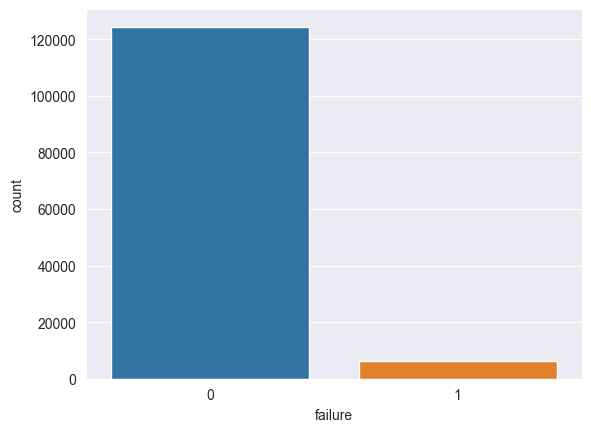

In [288]:
sns.countplot(data=df_resampled, x='failure')

In [289]:
#ordenando novamente pelo device e date
df_resampled.sort_values(by=['device_encolder','date'], ascending=[True, True]).head(30)

date  attribute1  attribute2  attribute3  attribute4  attribute5  \
0   2015-01-01   215630672          56           0          52           6   
1   2015-01-02     1650864          56           0          52           6   
2   2015-01-03   124017368          56           0          52           6   
3   2015-01-04   128073224          56           0          52           6   
4   2015-01-05    97393448          56           0          52           6   
5   2015-01-06   128832128          56           0          52           6   
6   2015-05-06    14533968           0           0           0           5   
7   2015-05-07    46202296           0           0           0           5   
8   2015-05-08   214383720           0           0           0           5   
9   2015-05-09   243346080           0           0           0           5   
10  2015-05-10    85127128           0           0           0           5   
11  2015-05-11   115676688           0           0           0           5   
12  2015-01-01    61370680           0           3           0           6   
13  2015-01-02   191946112           0           3           0           6   
14  2015-01-03    77681360           0           3           0           6   
15  2015-01-04    82195688           0           3           0           6   
16  2015-01-05   224339296           0           3           0           6   
17  2015-01-06     7441792           0           3           0           6   
18  2015-01-01   173295968           0           0           0          12   
19  2015-01-02   192723440           0           0           0          12   
20  2015-01-03   214317232           0           0           0          12   
21  2015-01-04   236917296           0           0           0          12   
22  2015-01-05    17099072           0           0           0          12   
23  2015-01-06    37263504           0           0           0          12   
24  2015-01-07    62055216           0           0           0          12   
25  2015-01-08    82886232           0           0           0          12   
26  2015-01-09   109504512           0           0           0          12   
27  2015-01-10   130876064           0           0           0          12   
28  2015-01-11   154306584           0           0           0          12   
29  2015-01-12   174969224           0           0           0          12   

    attribute6  attribute7  attribute9  flipper  ... attribute9_min  \
0       407438           0           7        1  ...            7.0   
1       407438           0           7        0  ...            7.0   
2       407438           0           7        0  ...            7.0   
3       407439           0           7        0  ...            7.0   
4       408114           0           7        0  ...            7.0   
5       409404           0           7        0  ...            7.0   
6       688952           0           0        1  ...            0.0   
7       688952           0           0        0  ...            0.0   
8       688964           0           0        0  ...            0.0   
9       689035           0           0        0  ...            0.0   
10      689062           0           0        0  ...            0.0   
11      689161           0           0        0  ...            0.0   
12      403174           0           0        1  ...            0.0   
13      403174           0           0        0  ...            0.0   
14      403174           0           0        0  ...            0.0   
15      403175           0           0        0  ...            0.0   
16      403812           0           0        0  ...            0.0   
17      404786           0           0        0  ...            0.0   
18      237394           0           0        1  ...            0.0   
19      238718           0           0        0  ...            0.0   
20      240021           0           0        0  ...            0.0   
21      241264           0   

### Tranformação dos dados

Os dados são bem dispersos, então para a transformação vou utilizar a média, mediana, o máximo e o minímo das colunas de telemetria.

In [290]:
def tranform_new_data(colum):
    df_resampled[colum+'_mean'] =np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1,window=window).mean()), df_resampled[colum])
    df_resampled[colum+'_median'] =np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1,window=window).median()), df_resampled[colum])
    df_resampled[colum+'_max'] = np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1, window=window).max()), df_resampled[colum])
    df_resampled[colum+'_min'] = np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1, window=window).min()), df_resampled[colum])

#Colunas para transformação
for i in df_resampled.columns[1:9]:
    tranform_new_data(df_resampled[i].name)

In [291]:
df_resampled.head()

date  attribute1  attribute2  attribute3  attribute4  attribute5  \
0  2015-01-01   215630672          56           0          52           6   
1  2015-01-02     1650864          56           0          52           6   
2  2015-01-03   124017368          56           0          52           6   
3  2015-01-04   128073224          56           0          52           6   
4  2015-01-05    97393448          56           0          52           6   

   attribute6  attribute7  attribute9  flipper  ... attribute9_min  \
0      407438           0           7        1  ...            7.0   
1      407438           0           7        0  ...            7.0   
2      407438           0           7        0  ...            7.0   
3      407439           0           7        0  ...            7.0   
4      408114           0           7        0  ...            7.0   

   attribute1_chg  attribute2_chg  attribute3_chg  attribute4_chg  \
0             1.0             1.0             0.0             1.0   
1             1.0             1.0             0.0             1.0   
2             1.0             1.0             0.0             1.0   
3             1.0             1.0             0.0             1.0   
4             1.0             1.0             0.0             1.0   

   attribute5_chg  attribute6_chg  attribute7_chg  attribute9_chg  failure  
0             1.0             1.0             0.0             1.0        0  
1             1.0             1.0             0.0             1.0        0  
2             1.0             1.0             0.0             1.0        0  
3             1.0             1.0             0.0             1.0        0  
4             1.0             1.0             0.0             1.0        0  

[5 rows x 55 columns]

Detectando os valores de pico para cada coluna, criando um valor que indica a distância entre o valor atual e a norma no intante avaliado.

In [292]:
df_resampled['attribute1_chg'] = np.where((df_resampled.attribute1_mean == 0),0 , df_resampled.attribute1/df_resampled.attribute1_mean)
df_resampled['attribute2_chg'] = np.where((df_resampled.attribute2_mean == 0),0 , df_resampled.attribute2/df_resampled.attribute2_mean)
df_resampled['attribute3_chg'] = np.where((df_resampled.attribute3_mean == 0),0 , df_resampled.attribute3/df_resampled.attribute3_mean)
df_resampled['attribute4_chg'] = np.where((df_resampled.attribute4_mean == 0),0 , df_resampled.attribute4/df_resampled.attribute4_mean)
df_resampled['attribute5_chg'] = np.where((df_resampled.attribute5_mean == 0),0 , df_resampled.attribute5/df_resampled.attribute5_mean)
df_resampled['attribute6_chg'] = np.where((df_resampled.attribute6_mean == 0),0 , df_resampled.attribute6/df_resampled.attribute6_mean)
df_resampled['attribute7_chg'] = np.where((df_resampled.attribute7_mean == 0),0 , df_resampled.attribute7/df_resampled.attribute7_mean)
df_resampled['attribute9_chg'] = np.where((df_resampled.attribute9_mean == 0),0 , df_resampled.attribute9/df_resampled.attribute9_mean)

In [293]:
df_resampled.head()


date  attribute1  attribute2  attribute3  attribute4  attribute5  \
0  2015-01-01   215630672          56           0          52           6   
1  2015-01-02     1650864          56           0          52           6   
2  2015-01-03   124017368          56           0          52           6   
3  2015-01-04   128073224          56           0          52           6   
4  2015-01-05    97393448          56           0          52           6   

   attribute6  attribute7  attribute9  flipper  ... attribute9_min  \
0      407438           0           7        1  ...            7.0   
1      407438           0           7        0  ...            7.0   
2      407438           0           7        0  ...            7.0   
3      407439           0           7        0  ...            7.0   
4      408114           0           7        0  ...            7.0   

   attribute1_chg  attribute2_chg  attribute3_chg  attribute4_chg  \
0             1.0             1.0             0.0             1.0   
1             1.0             1.0             0.0             1.0   
2             1.0             1.0             0.0             1.0   
3             1.0             1.0             0.0             1.0   
4             1.0             1.0             0.0             1.0   

   attribute5_chg  attribute6_chg  attribute7_chg  attribute9_chg  failure  
0             1.0             1.0             0.0             1.0        0  
1             1.0             1.0             0.0             1.0        0  
2             1.0             1.0             0.0             1.0        0  
3             1.0             1.0             0.0             1.0        0  
4             1.0             1.0             0.0             1.0        0  

[5 rows x 55 columns]

In [294]:
df = df_resampled

### Separação dos dados entre treino e teste por estratificação

In [295]:
from sklearn.model_selection import train_test_split
# Separando as features e o target
X = df.drop('failure', axis=1)
y = df['failure']
stratify_col = df['device_encolder']

# dividindo o conjunto de dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratify_col, test_size=0.15, random_state=45)

# Verificando as proporções das classes nos conjuntos de treino e teste
print('Proporção de classe no conjunto de treino:', y_train.value_counts(normalize=True))
print('Proporção de classe no conjunto de teste:', y_test.value_counts(normalize=True))

# Exibindo a quantidade de registros em cada conjunto de dados
print('\nNúmero de registros no conjunto de treino:', len(X_train))
print('Número de registros no conjunto de teste:', len(X_test))

# Exibindo a contagem de valores únicos na coluna 'failure' para cada conjunto de dados
print('\nContagem de valores failure no conjunto de treino:')
print(y_train.value_counts())

print('\nContagem de valores failure no conjunto de teste:')
print(y_test.value_counts())

Proporção de classe no conjunto de treino: 0    0.952446
1    0.047554
Name: failure, dtype: float64
Proporção de classe no conjunto de teste: 0    0.952274
1    0.047726
Name: failure, dtype: float64

Número de registros no conjunto de treino: 111010
Número de registros no conjunto de teste: 19591

Contagem de valores failure no conjunto de treino:
0    105731
1      5279
Name: failure, dtype: int64

Contagem de valores failure no conjunto de teste:
0    18656
1      935
Name: failure, dtype: int64


In [296]:
#Tranformando novamente as colunas de data
# df_resampled['date'] = pd.to_datetime(df_resampled['date'],unit='s')
# df_resampled['start_date'] = pd.to_datetime(df_resampled['start_date'],unit='s')
#
# df_resampled['start_date'] = df_resampled['start_date'].dt.strftime('%Y-%m-%d')
# df_resampled['date'] = df_resampled['date'].dt.strftime('%Y-%m-%d')

### Oversampling mais agressivo com SMOTE nos dados de treino

In [297]:
oversamplit_SMOTE(X_train)

KeyError: "['failure'] not found in axis"